In [1]:
import colorsys
import glob
from IPython import display
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import time
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [2]:
data = pd.read_csv("output/participant_test.txt", header=None).to_numpy()
print(data.shape)

no_data = round(len(data)*0.8)
train_set = data[:no_data]
test_set = data[no_data:]
print(train_set.shape, test_set.shape)

(402, 14)
(322, 14) (80, 14)


In [3]:
anchors = train_set[:, :3]
bgcolors = train_set[:, 9:12]

positive, negative = [], []
for i in range(train_set.shape[0]):
    if data[i, 13] == 0:
        positive.append(train_set[i, 3:6])
        negative.append(train_set[i, 6:9])
    else:
        positive.append(train_set[i, 6:9])
        negative.append(train_set[i, 3:6])

positive = np.array(positive)
negative = np.array(negative)

In [4]:
anchors2 = test_set[:,:3]
bgcolors2 = test_set[:,9:12]

positive2 = []
negative2 = []
for i in range(test_set.shape[0]):
    if test_set[i, 13]==0:
        positive2.append(test_set[i, 3:6])
        negative2.append(test_set[i, 6:9])
    else:
        positive2.append(test_set[i, 6:9])
        negative2.append(test_set[i, 3:6])

positive2 = np.array(positive2)
negative2 = np.array(negative2)

## First model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = self.l1(x)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = self.l2(z)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

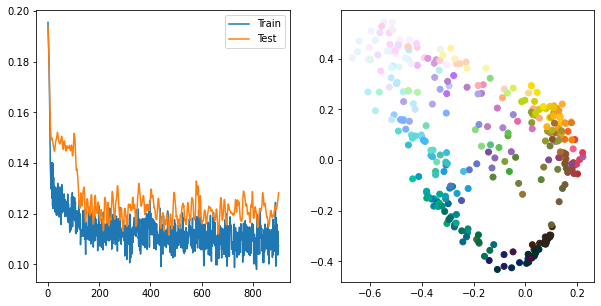

<Figure size 432x288 with 0 Axes>

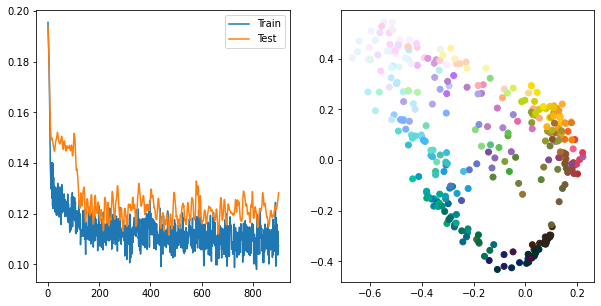

In [6]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.TripletMarginLoss(0.2)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(1000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()

## Second model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = self.l1(x)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = self.l2(z)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

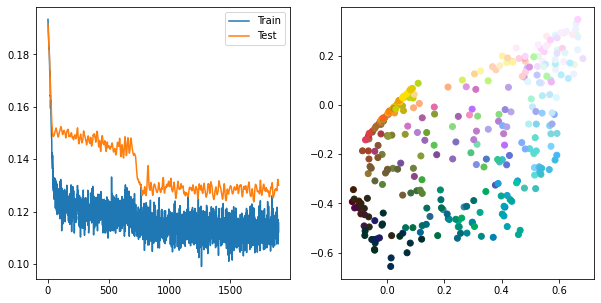

<Figure size 432x288 with 0 Axes>

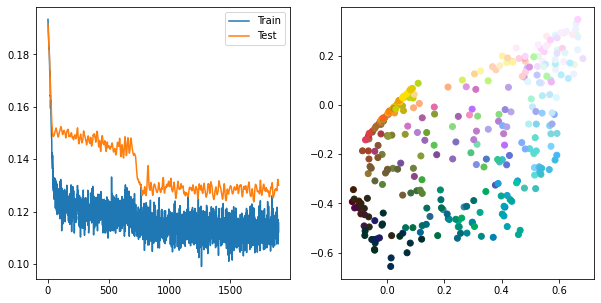

In [8]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_func = nn.TripletMarginLoss(0.2)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(2000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = self.l1(x)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = self.l2(z)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

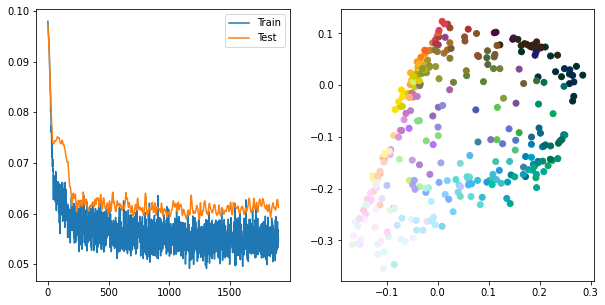

<Figure size 432x288 with 0 Axes>

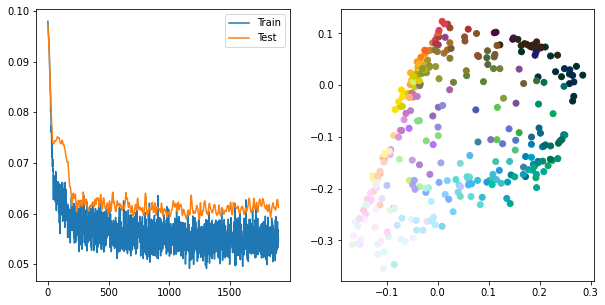

In [10]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_func = nn.TripletMarginLoss(0.1)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(2000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = self.l1(x)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = self.l2(z)
        z = torch.cat([torch.sin(z[:, :4]), F.relu(z[:, 4:])],1)
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

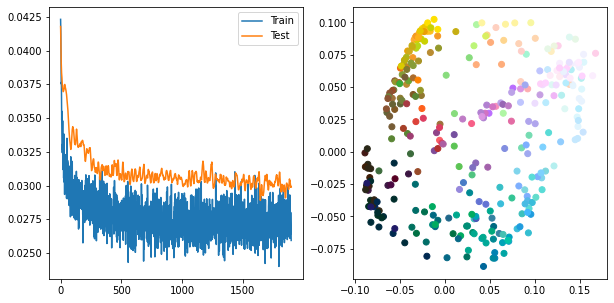

<Figure size 432x288 with 0 Axes>

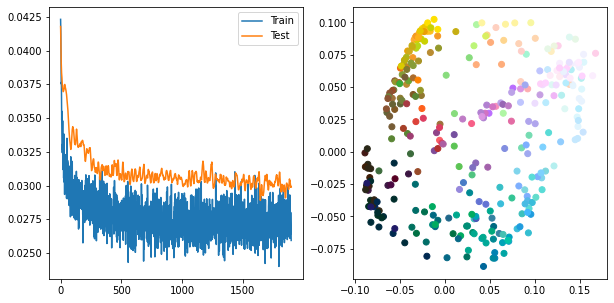

In [12]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_func = nn.TripletMarginLoss(0.05)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(2000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

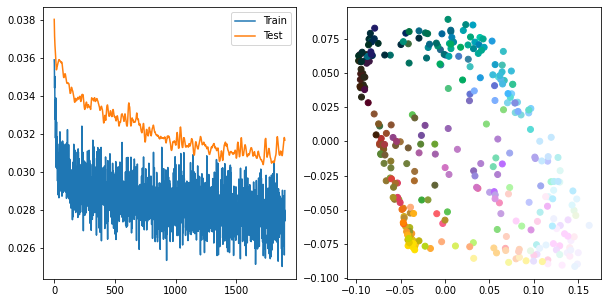

<Figure size 432x288 with 0 Axes>

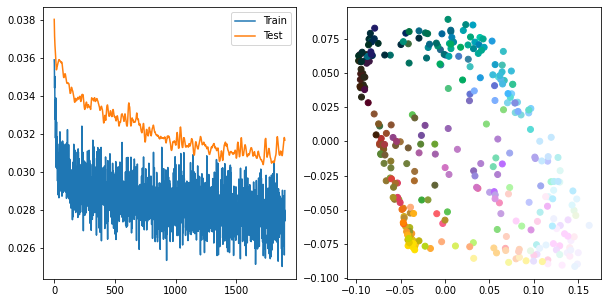

In [14]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.TripletMarginLoss(0.05)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(2000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

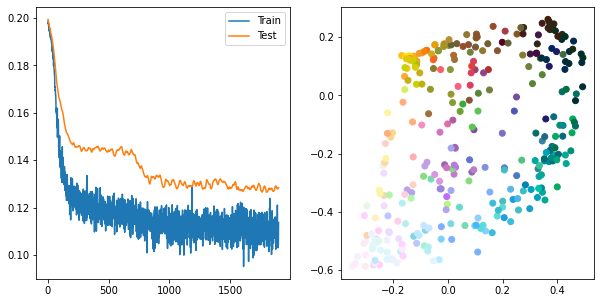

<Figure size 432x288 with 0 Axes>

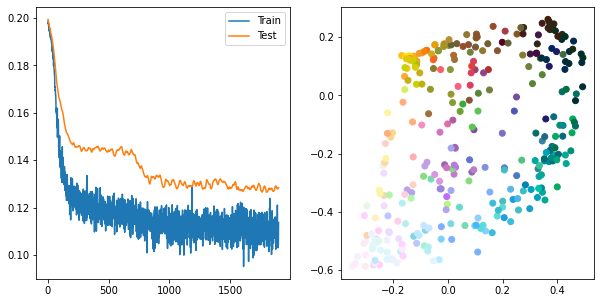

In [16]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.TripletMarginLoss(0.2)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(2000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

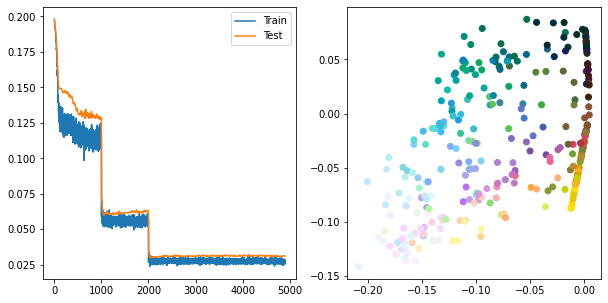

<Figure size 432x288 with 0 Axes>

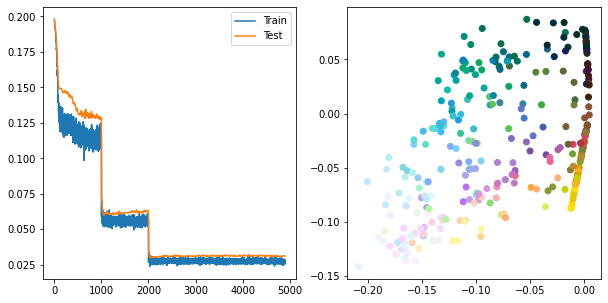

In [20]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.TripletMarginLoss(0.2)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(5000):
    # Train
    model.train()
    z1 = model.forward(x1+torch.randn_like(x1)*0.1)
    z2 = model.forward(x2+torch.randn_like(x1)*0.1)
    z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        print(f'Train: {tr_err[-1]}')
        print(f'Test: {ts_err[-1]}')

        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()
        
    if epoch == 1000:
        loss_func = nn.TripletMarginLoss(0.1)
        
    if epoch == 2000:
        loss_func = nn.TripletMarginLoss(0.05)

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3, 8)
        self.l2 = nn.Linear(8, 8)
        self.l3 = nn.Linear(8, 8)
        self.l4 = nn.Linear(8, 2)
        
    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        z = F.relu(self.l3(z))
        z = torch.tanh(self.l4(z))
        return z

# model = Net()
# model.forward(torch.rand([1, 6]), torch.rand([1, 3]))

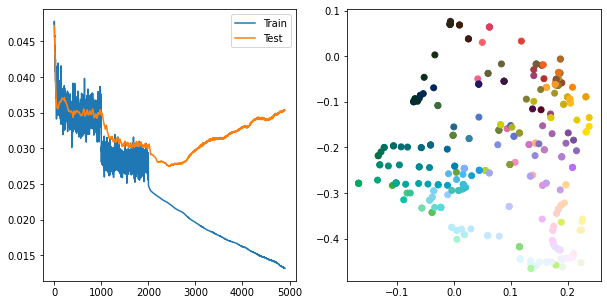

<Figure size 432x288 with 0 Axes>

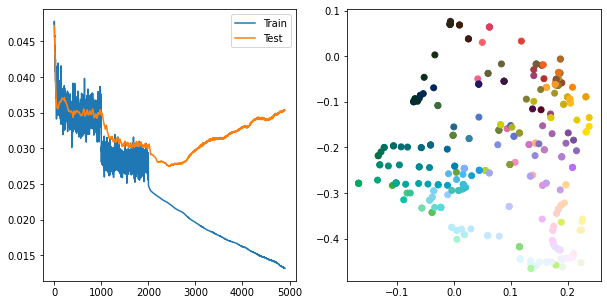

In [29]:
model = Net()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.TripletMarginLoss(0.05)

x1 = torch.FloatTensor(anchors) / 256.0
x2 = torch.FloatTensor(positive) / 256.0
x3 = torch.FloatTensor(negative) / 256.0

x1t = torch.FloatTensor(anchors2) / 256.0
x2t = torch.FloatTensor(positive2) / 256.0
x3t = torch.FloatTensor(negative2) / 256.0

x1c = x1.cpu().detach().numpy()

tr_err, ts_err = [], []
for epoch in range(5000):
    # Train
    model.train()
    if epoch < 1000:
        z1 = model.forward(x1+torch.randn_like(x1)*0.2)
        z2 = model.forward(x2+torch.randn_like(x1)*0.2)
        z3 = model.forward(x3+torch.randn_like(x1)*0.2)
    elif epoch < 2000:
        z1 = model.forward(x1+torch.randn_like(x1)*0.1)
        z2 = model.forward(x2+torch.randn_like(x1)*0.1)
        z3 = model.forward(x3+torch.randn_like(x1)*0.1)
    else:
        z1 = model.forward(x1)
        z2 = model.forward(x2)
        z3 = model.forward(x3)
    
    loss = loss_func(z1, z2, z3)
    tr_err.append(loss.cpu().detach().item())
    
    optim.zero_grad(set_to_none=True)
    for p in model.parameters():
        loss += 0.01*torch.mean(p**2)
    loss.backward()    
    optim.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        z1t = model.forward(x1t)
        z2t = model.forward(x2t)
        z3t = model.forward(x3t)

        loss = loss_func(z1t, z2t, z3t)
        ts_err.append(loss.cpu().detach().item())
    
    if epoch % 100 == 0:
        print(f'Train: {tr_err[-1]}')
        print(f'Test: {ts_err[-1]}')

        plt.clf()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(tr_err, label='Train')
        axs[0].plot(ts_err, label='Test')
        axs[0].legend()
        
        z1c = z1.cpu().detach().numpy()
        axs[1].scatter(z1c[:, 0], z1c[:, 1], c=x1c)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        plt.show()